In [1]:
%matplotlib inline
import numpy as np
import jax.numpy as jnp
from jax.ops import index, index_update
from jax.config import config
from tqdm.notebook import trange

from os.path import join
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme('talk', 'white')
plt.rcParams["figure.figsize"] = (8,8)

config.update("jax_enable_x64", True)

data_folder = join(join('..', 'data'), 'congedo')

In [2]:
# Functions
isqrt = lambda x: 1. / jnp.sqrt(x)
funs = {'sqrt': jnp.sqrt,
        'isqrt': isqrt,
        'log': jnp.log,
        'exp': jnp.exp}

def norm_frob_squared(X):
    return jnp.einsum('...ji,...ji', X, X)

def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

def transform_mat(X, func='sqrt'):
    u, v = jnp.linalg.eigh(X)
    return jnp.einsum('...ij,...j,...kj', v, funs[func](u), v)

def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = jnp.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

def costfunc(X, Y):
    return jnp.sum(dist_riem_squared(X, Y))

def costfuncproc(X, Y):
    return jnp.sum(dist_frob_squared(X, Y))

def rotate(X, Omega):
    return np.einsum('...ij,...jk,...lk', Omega, X, Omega)

def optimal_rotation(X, M):
    _, g_m = np.linalg.eigh(M)
    _, g_x = np.linalg.eigh(X)
    return np.einsum('...ij,...kj', g_m, g_x)

def optimal_reference_eigval(X):
    u = np.linalg.eigvalsh(X)
    return np.exp(np.sum(np.log(u), axis=0) / X.shape[0])

def optimal_reference_eigvec(X):
    _, vs = np.linalg.eigh(Sigmas)
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    return np.einsum('...ij,...jk', U, V)

def optimal_reference(X):
    u, vs = jnp.linalg.eigh(X)
    eigval = jnp.exp(jnp.sum(jnp.log(u), axis=0) / X.shape[0])
    U, _, V = jnp.linalg.svd(jnp.sum(vs, axis=0))
    eigvec = jnp.einsum('...ij,...jk', U, V)
    return jnp.einsum('...ij,...j,...kj', eigvec, eigval, eigvec)

def corr_from_cov(cov):
    diag = np.sqrt(np.diag(cov))
    return np.einsum('...i,...ij,...j->...ij', 1./diag, cov, 1./diag)


In [3]:
def extract_covs(subject):
    head = pd.read_csv(join(data_folder, 'header.csv')).columns
    data = pd.read_csv(join(data_folder, "subject_{:02}.csv".format(subject)),
                            header=None,
                            names=head).set_index('Time')

    S = data.iloc[:, :16].to_numpy()
    stim = (1 * data.EyesClosed + 2 * data.EyesOpened).to_numpy()

    chnames = ['Fp1',
               'Fp2',
               'FC5',
               'Fz',
               'FC6',
               'T7',
               'Cz',
               'T8',
               'P7',
               'P3',
               'Pz',
               'P4',
               'P8',
               'O1',
               'Oz',
               'O2',
               'stim'
              ]
    chtypes = ['eeg'] * 16 + ['stim']

    X = np.concatenate([S, np.expand_dims(stim, -1)], axis=1).T
    info = mne.create_info(ch_names=chnames, sfreq=512, ch_types=chtypes, verbose=False)
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(data=X, info=info, verbose=False)
    
    fmin = 3
    fmax = 40
    raw.filter(fmin, fmax, verbose=False)
    raw.resample(sfreq=128, verbose=False)

    events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
    event_id = {'closed':1, 'open':2}
    epochs = mne.Epochs(raw, events, event_id,
                        tmin=2.0, tmax=8.0,
                        baseline=(None, None), 
                        verbose=False, preload=True)
    
    epochs.pick_types(eeg=True)

    cova_open = mne.compute_covariance(epochs['open'],
                                   #method='ledoit_wolf',
                                   scalings={'eeg':1e6},
                                   verbose=False,
                                  )
    cova_clos = mne.compute_covariance(epochs['closed'],
                                   #method='ledoit_wolf',
                                   scalings={'eeg':1e6},
                                   verbose=False,
                                  )

    #X = epochs.get_data()
    #X = (X - np.expand_dims(X.mean(axis=-1), -1)) / np.expand_dims(X.std(axis=-1), -1)
    #covs = np.einsum('...ij,...kj', X, X) / X.shape[-1]
    
    covs = np.concatenate([np.expand_dims(cova_open['data'] / cova_open.nfree, 0),
                           np.expand_dims(cova_clos['data'] / cova_clos.nfree, 0)], axis=0)
    
    y = ['open', 'closed']

    return covs, y


def extract_covs_brute(subject):
    head = pd.read_csv(join(data_folder, 'header.csv')).columns
    data = pd.read_csv(join(data_folder, "subject_{:02}.csv".format(subject)),
                            header=None,
                            names=head).set_index('Time')

    closed = np.zeros(shape=len(data), dtype=bool)
    for i, x in enumerate(data.itertuples()):
        if x.EyesClosed:
            closed[i] = True
        elif x.EyesOpened:
            closed[i] = False
        elif closed[i-1]:
            closed[i] = True

    cl = data[closed].iloc[:, :-2]
    op = data[~closed].iloc[:, :-2]
    n_cl = len(cl); n_op = len(op)
    
    cl = cl.apply(lambda x: (x - x.mean()) / x.std(), axis=0).to_numpy()
    op = op.apply(lambda x: (x - x.mean()) / x.std(), axis=0).to_numpy()
    
    covs = np.concatenate([np.expand_dims(op.T @ op / n_op, 0), 
                           np.expand_dims(cl.T @ cl / n_cl, 0)], axis=0)
    
    y = ['open', 'closed']
    lens = [n_op, n_cl]
    return covs, y, lens

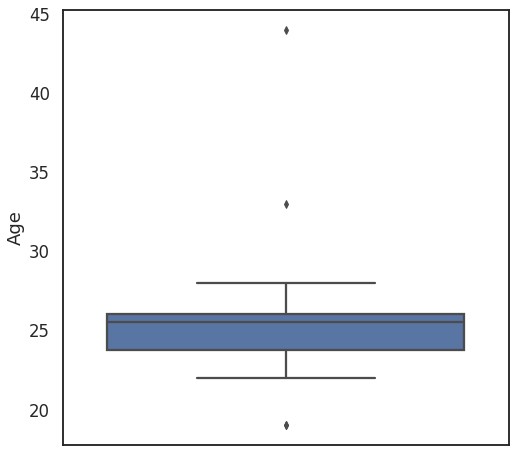

In [4]:
#### Demographics:
demographics = pd.read_csv(join(data_folder, 'demographic.csv'),
                           header=None,
                           names=pd.read_csv(join(data_folder, 'demographic_header.csv')).columns
                          )
demographics.set_index('Subject', inplace=True)
demographics['IsMan'] = demographics.IsMan.astype(bool)
demographics['Gender'] = demographics.IsMan.apply(lambda x: 'Man' if x else 'Woman')

sns.boxplot(data=demographics, y='Age')
plt.show()

In [5]:
Sigmas = []
labels = []
ages = []
subjects = []
genders = []
lengths = []

for i in trange(20):
    subject = i + 1
    #print('Reading subject {:02}...'.format(subject))
    c, y, lens = extract_covs_brute(subject)
    Sigmas.append(c)
    labels += list(y)
    ages += [int(demographics.loc[subject, 'Age'])] * len(y)
    genders += ['Male' if demographics.loc[subject, 'IsMan'] else 'Female'] * len(y)
    subjects += [subject] * len(y)
    lengths += list(lens)

Sigmas = np.concatenate(Sigmas, axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
ref_eigvals = optimal_reference_eigval(Sigmas)
ref_eigvect = optimal_reference_eigvec(Sigmas)
reference = np.einsum('...ij,...j,...kj', ref_eigvect, ref_eigvals, ref_eigvect)

Omegas = optimal_rotation(Sigmas, reference)

Sigmas_rotated = rotate(Sigmas, Omegas)

In [7]:
#s_max_or, s_min_or = np.max(Sigmas), np.min(Sigmas)
#s_max_ro, s_min_ro = np.max(Sigmas_rotated), np.min(Sigmas_rotated)
s_max, s_min = 1., -1.

colmap = sns.diverging_palette(20, 220, n=200)

mask = np.zeros(shape=Sigmas.shape[1:])
mask[np.triu_indices_from(mask)] = True

base = 6
figsize = (base * 2, base * 20)

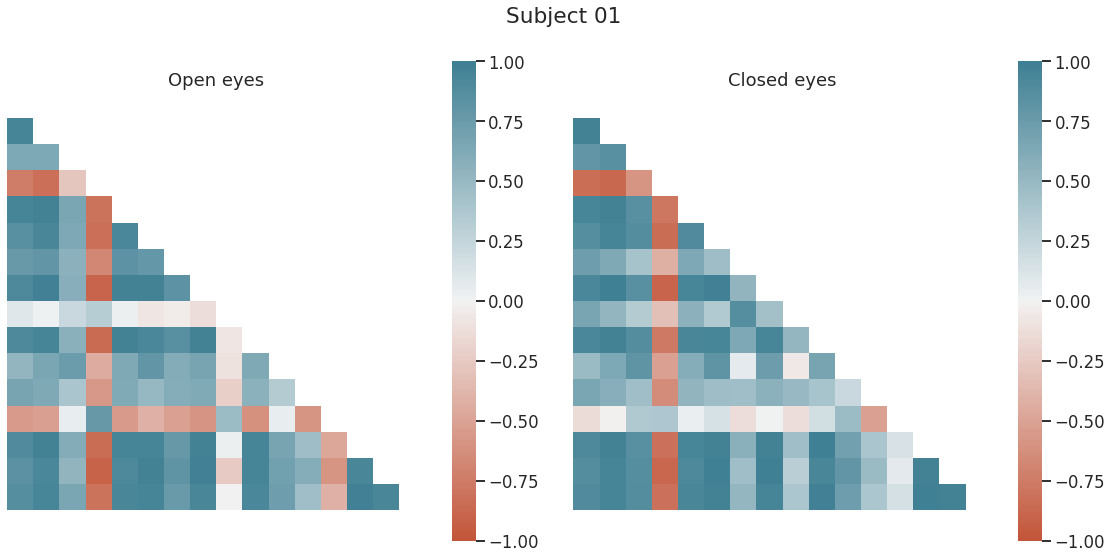

65.23145451121972


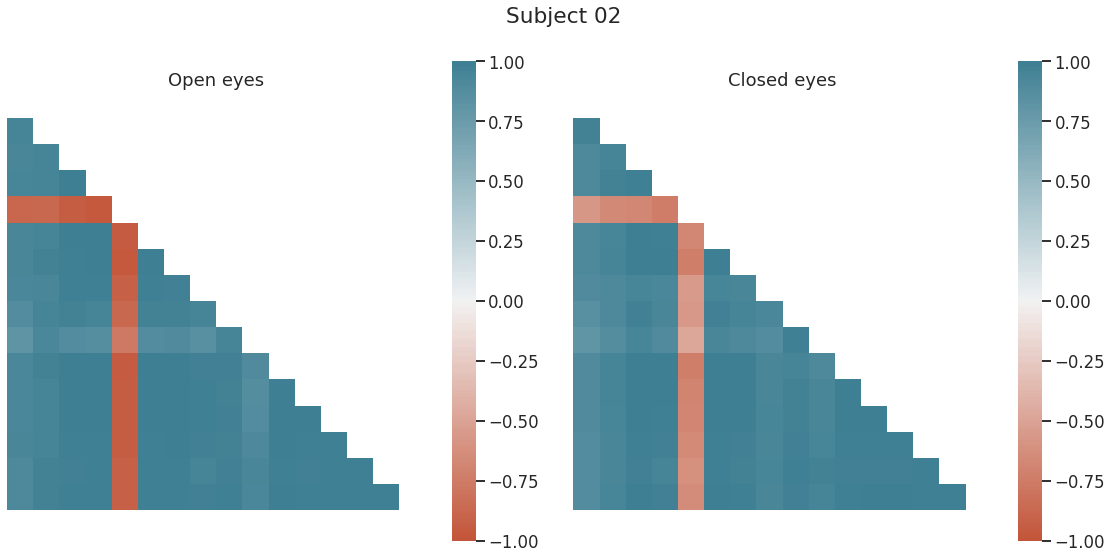

29.180311886815204


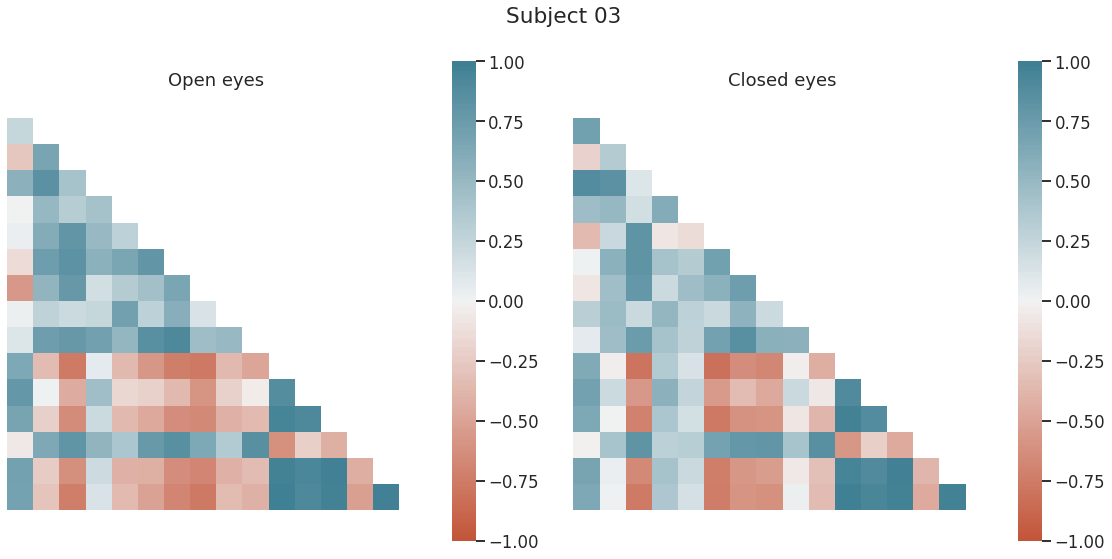

29.453056063374667


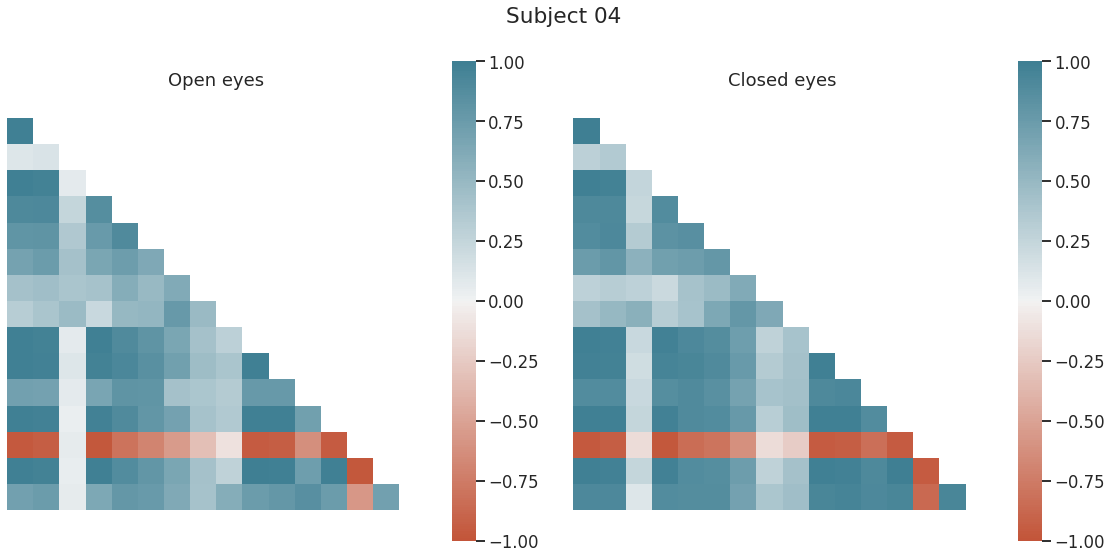

25.328405745793233


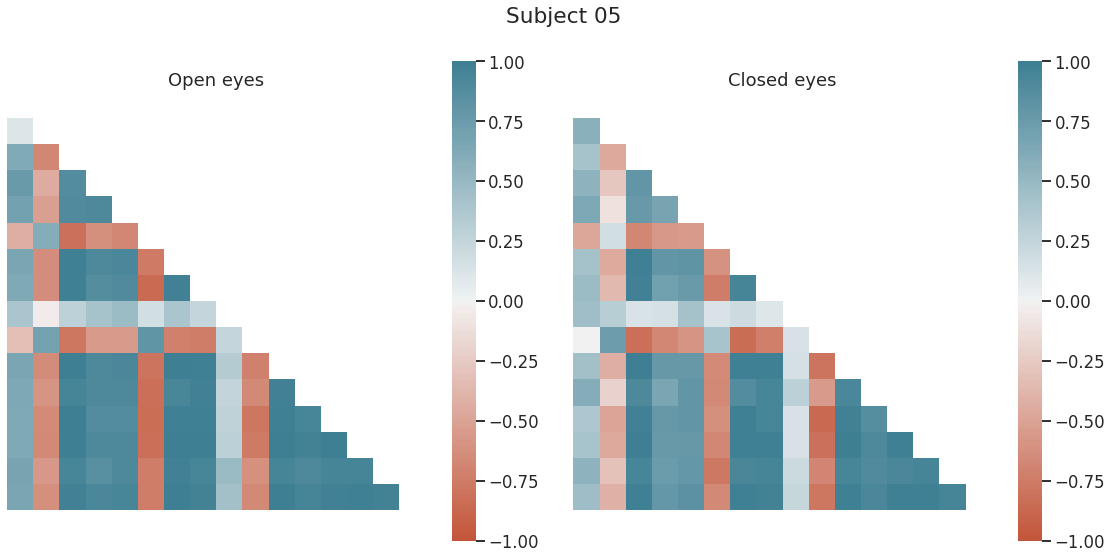

52.37281665102473


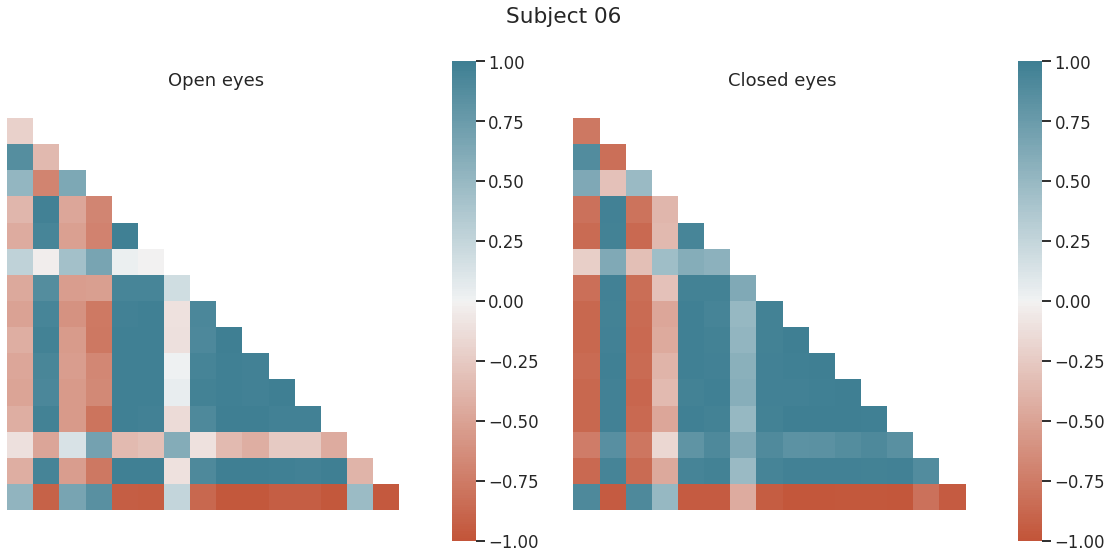

76.37303295458283


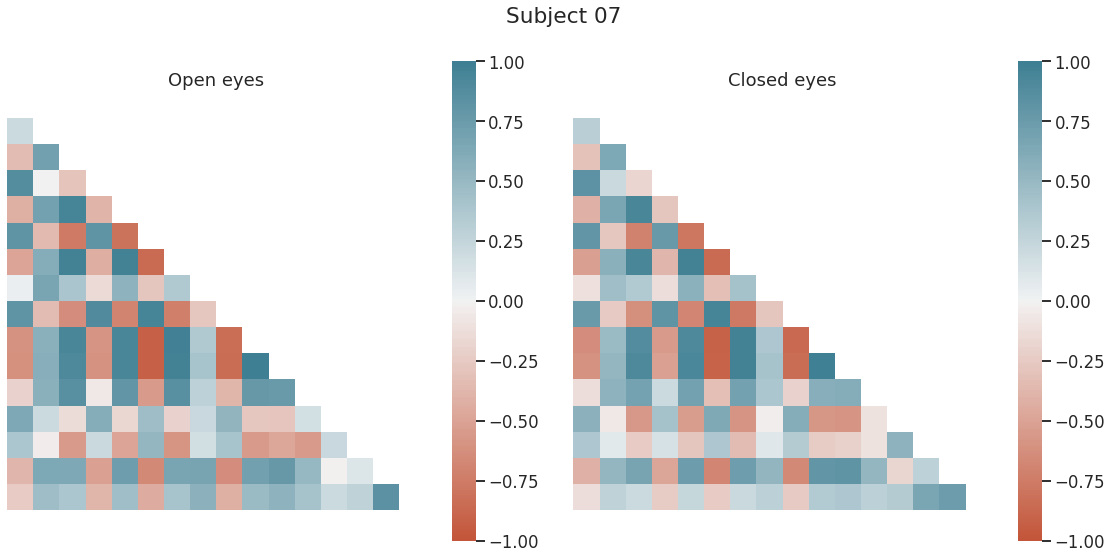

20.37590910936418


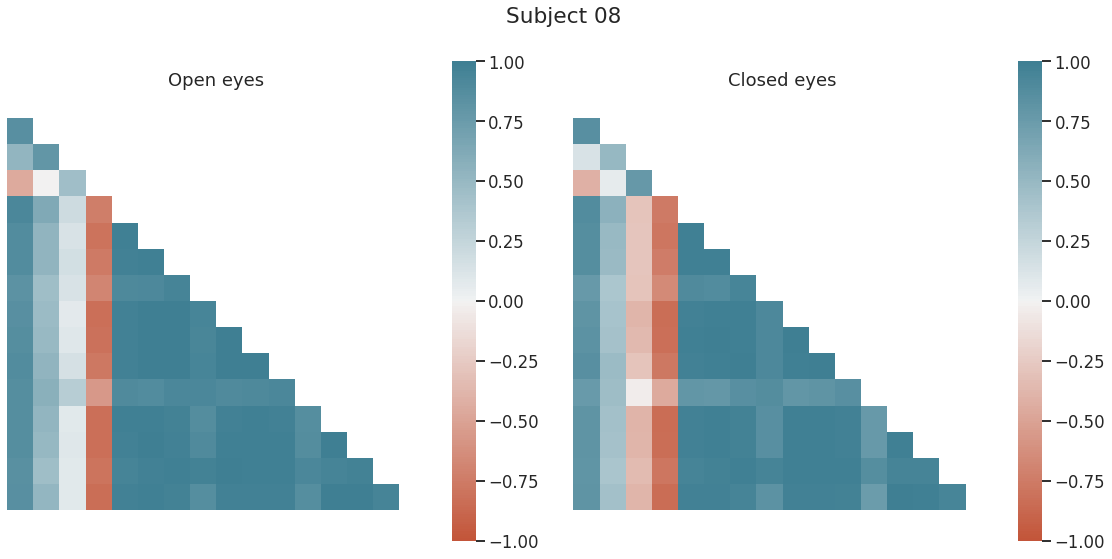

25.070774744805213


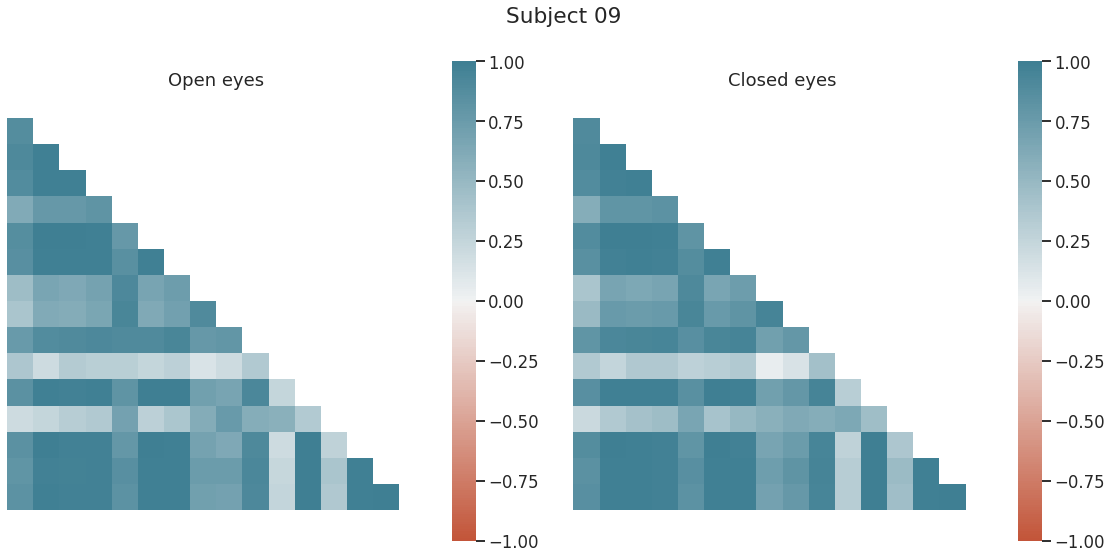

13.316273297217329


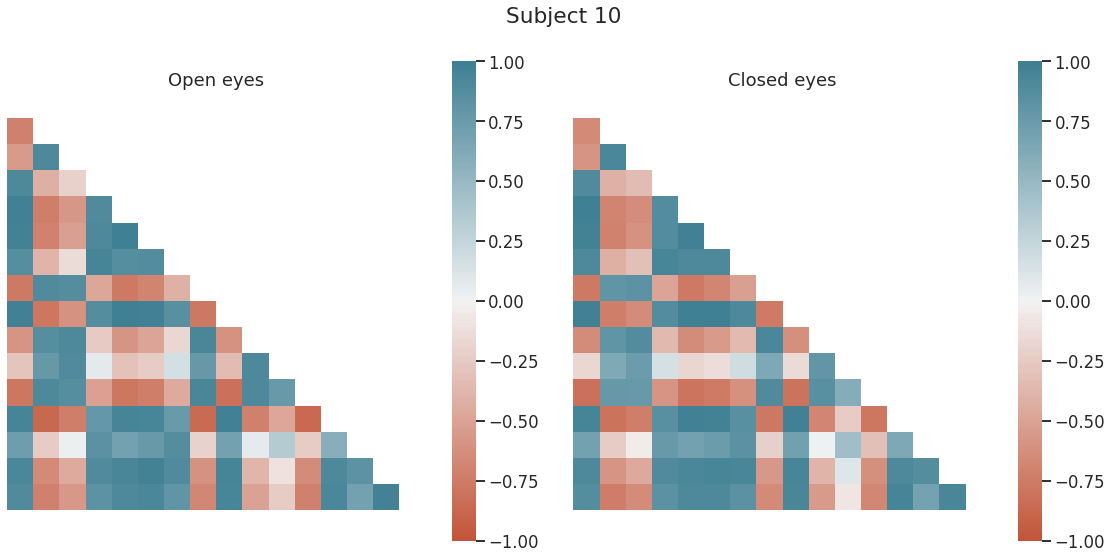

22.166787551999455


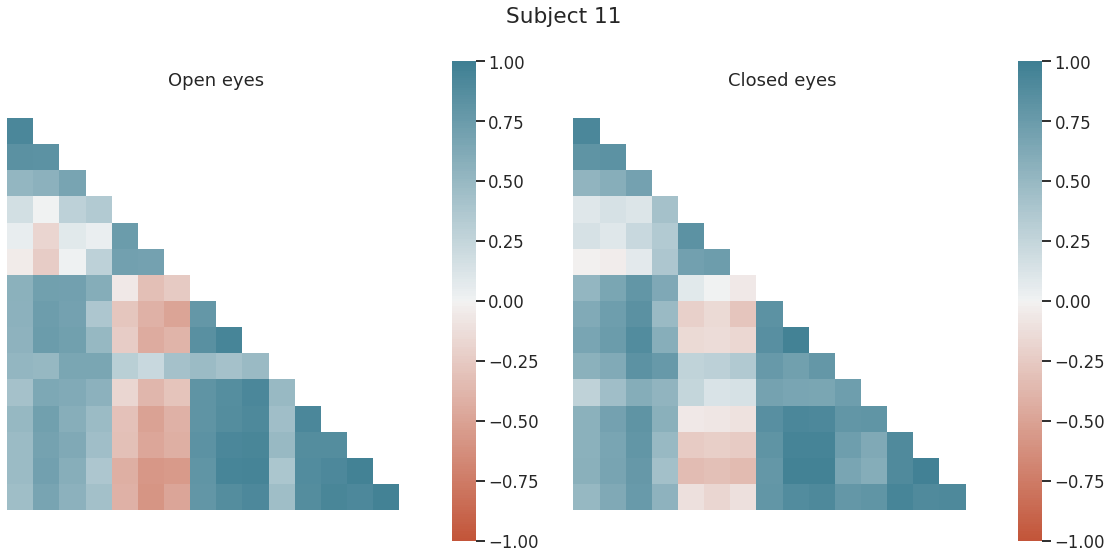

20.7741725084462


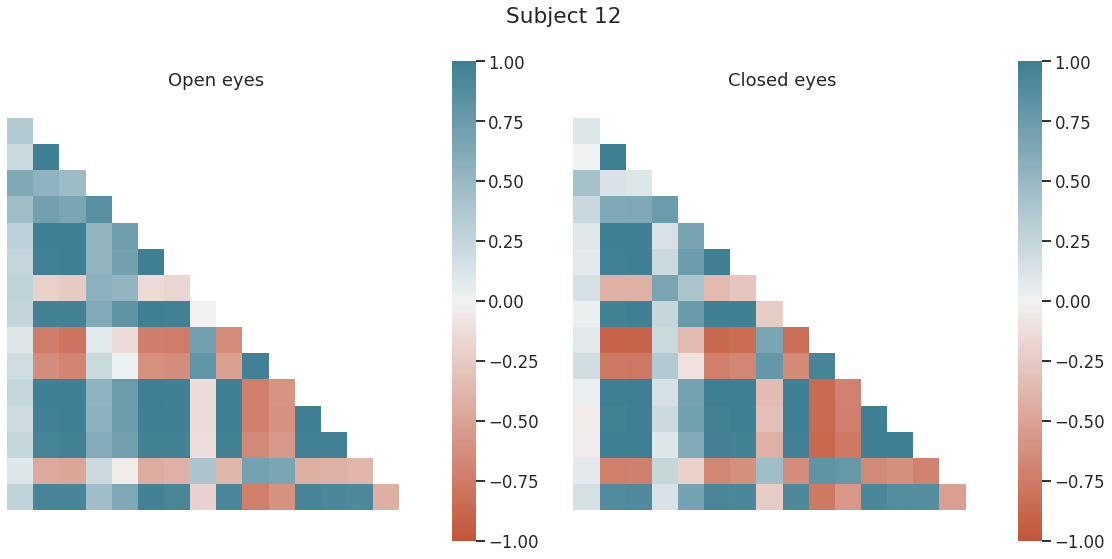

36.19646974278511


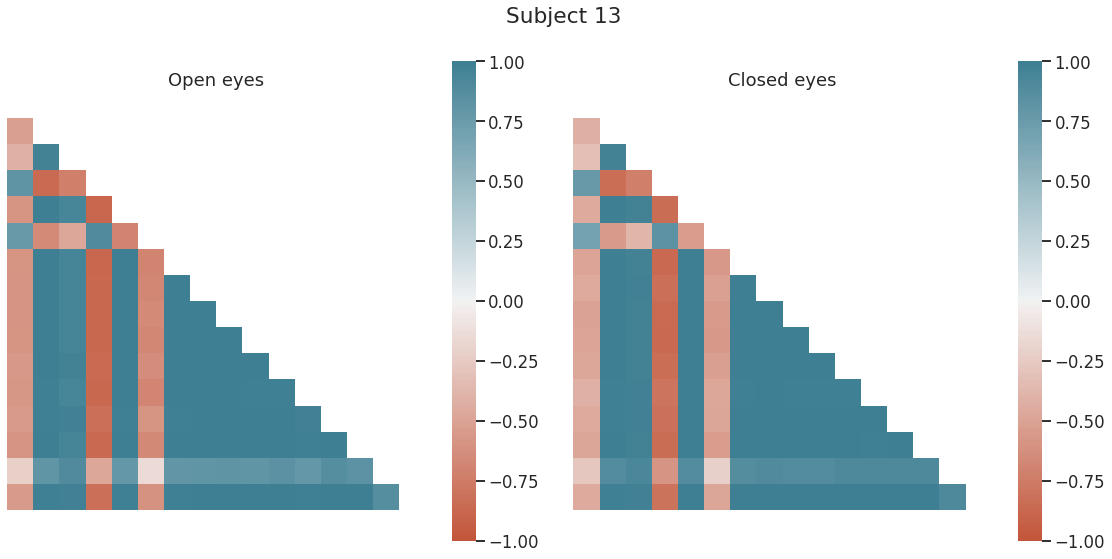

18.790392109562692


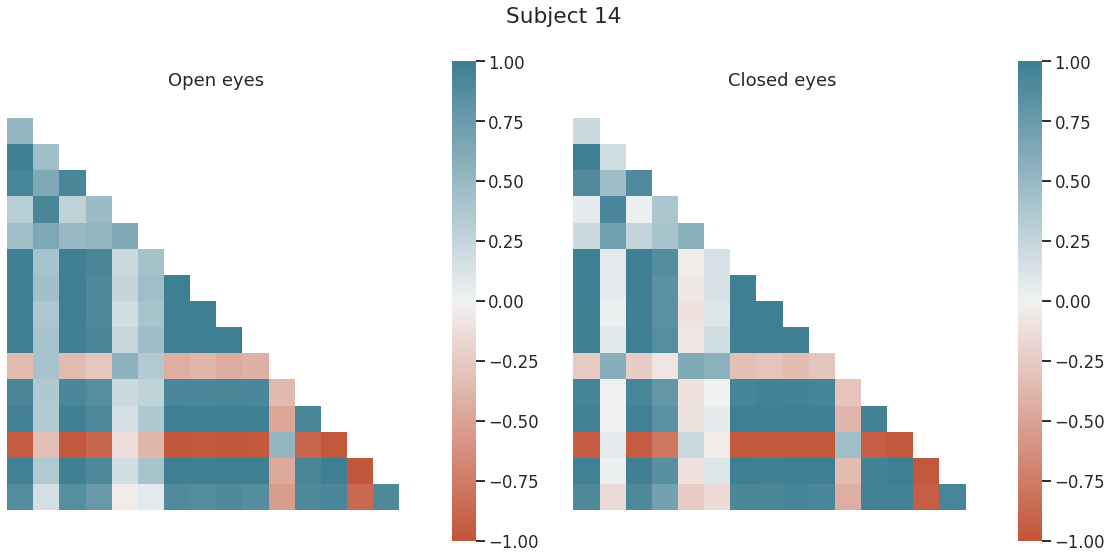

23.470911928205023


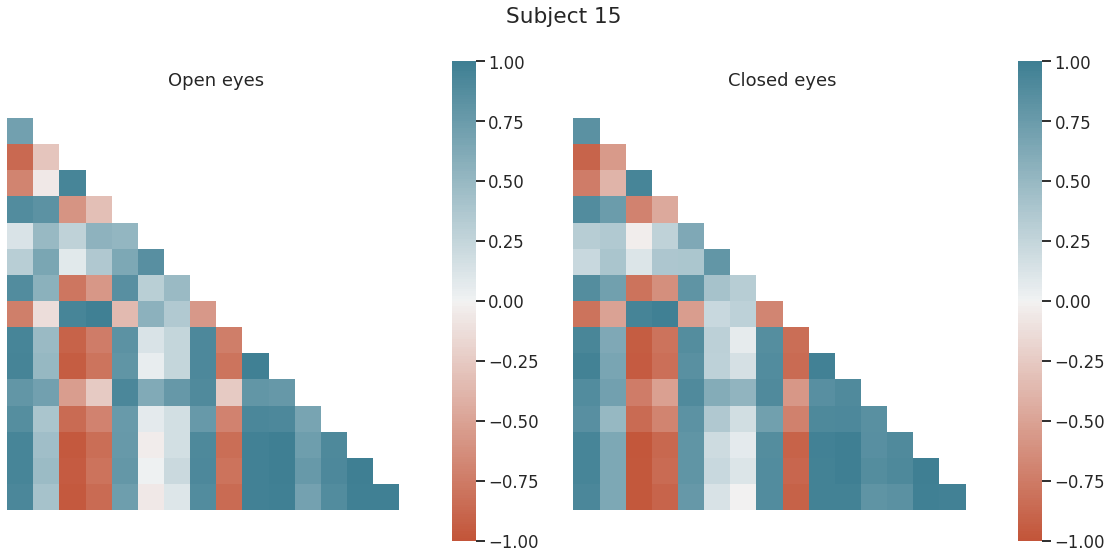

41.239692572627234


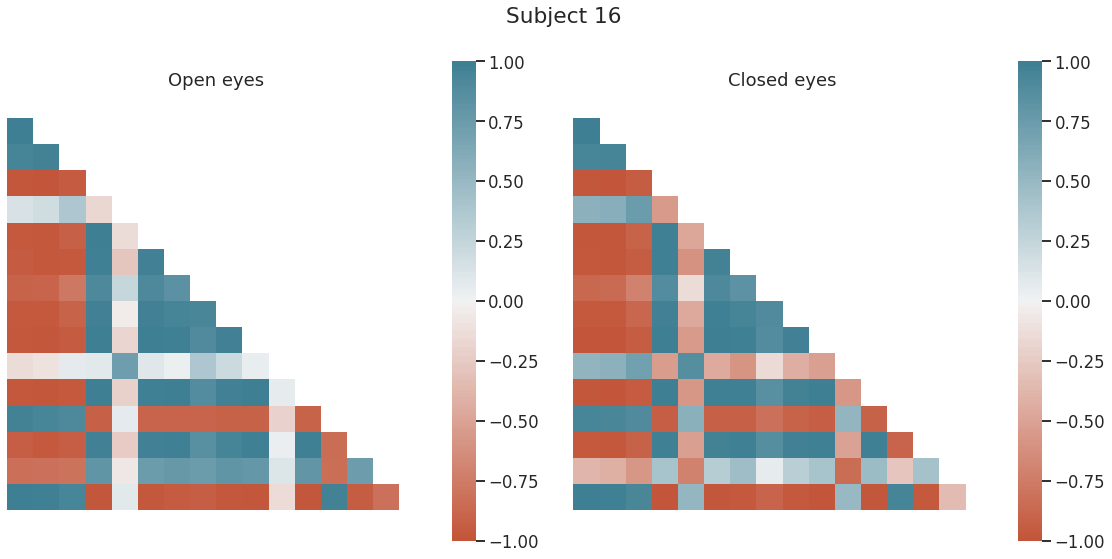

34.828842180126244


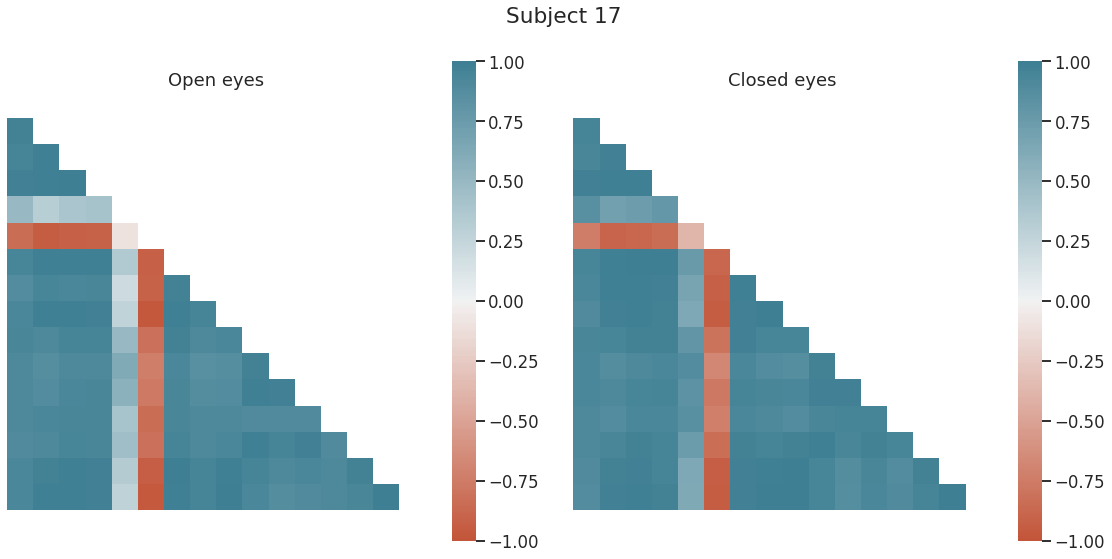

37.77410721019368


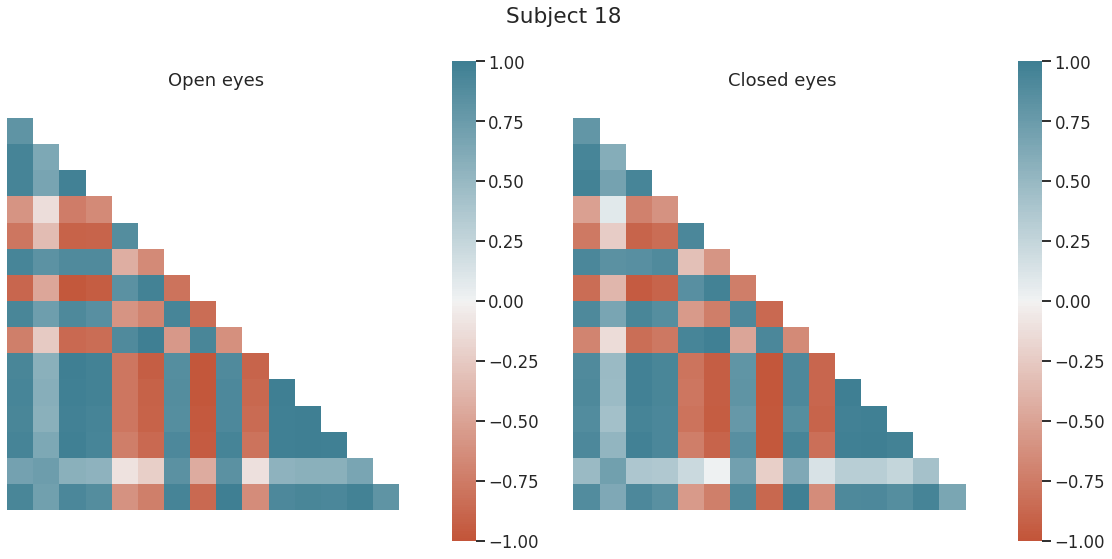

27.26401101992913


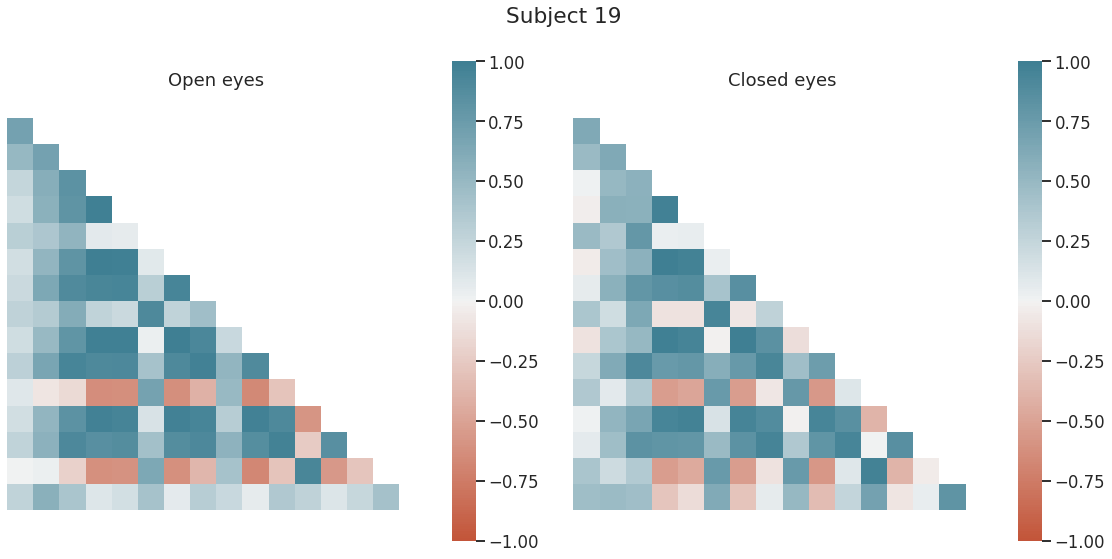

48.158532892226745


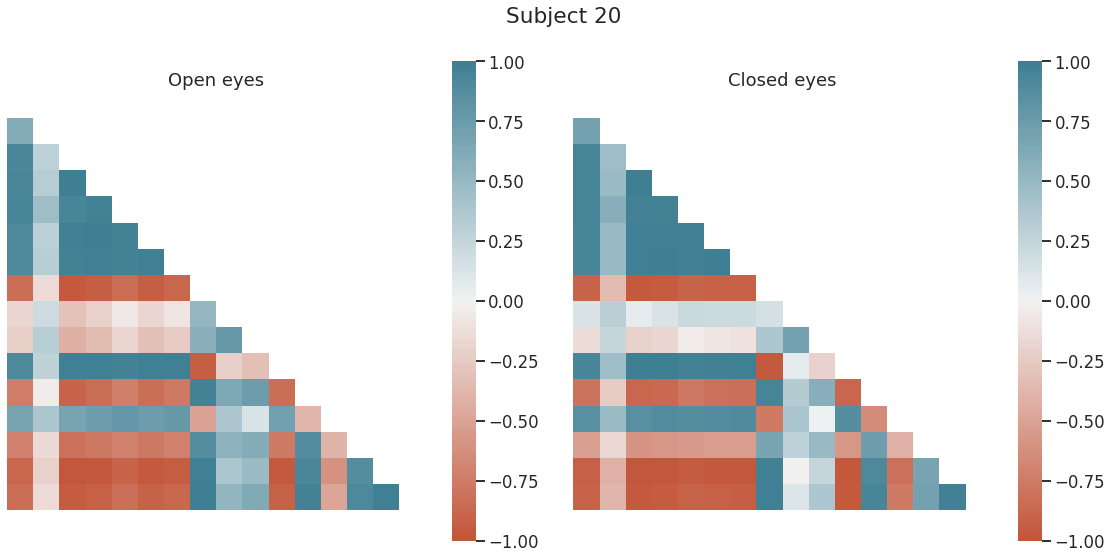

22.675437460386313


In [8]:
for i in np.arange(0, 40, 2):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
    sns.heatmap(data=corr_from_cov(Sigmas[i]),
                ax=ax[0],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=corr_from_cov(Sigmas[i+1]),
                ax=ax[1],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    ax[0].set_title('Open eyes')
    ax[1].set_title('Closed eyes')
    f.suptitle("Subject {:02}".format(int(i/2 + 1)))
    plt.tight_layout()
    plt.show()
    print(dist_riem_squared(Sigmas[i], Sigmas[i+1]))

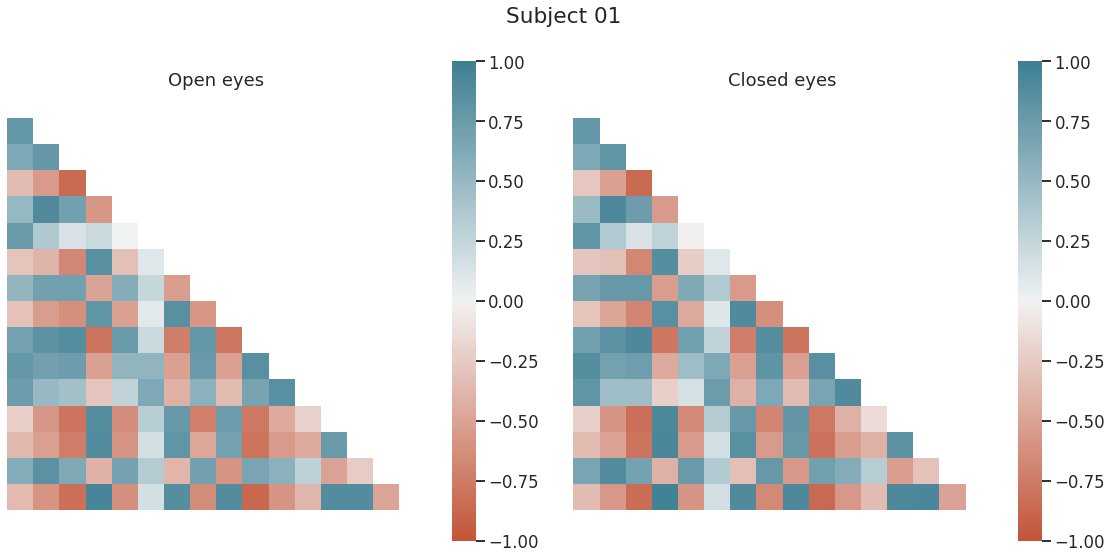

12.115810273015832


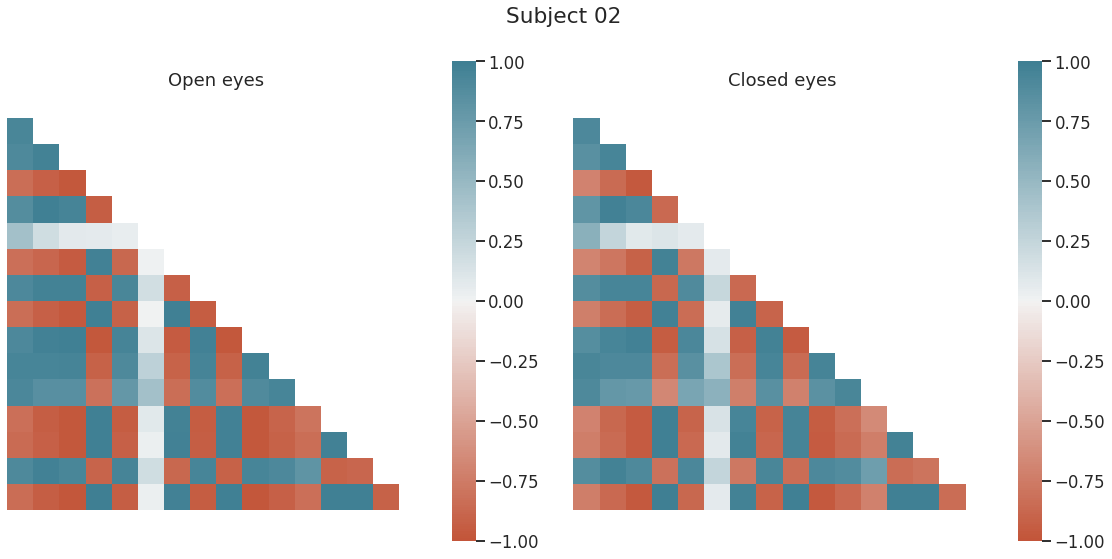

2.179493558321116


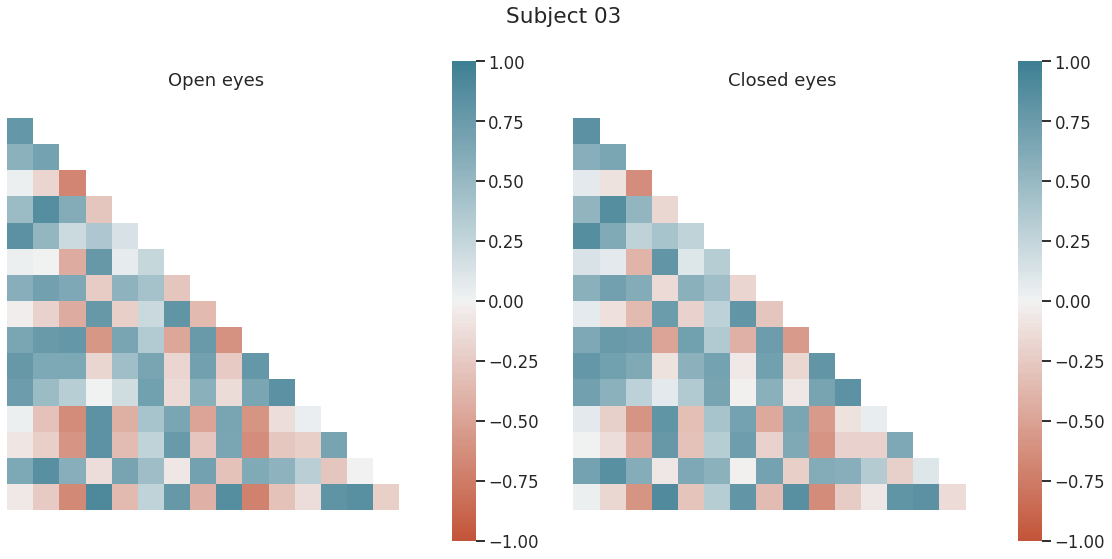

1.433988581742054


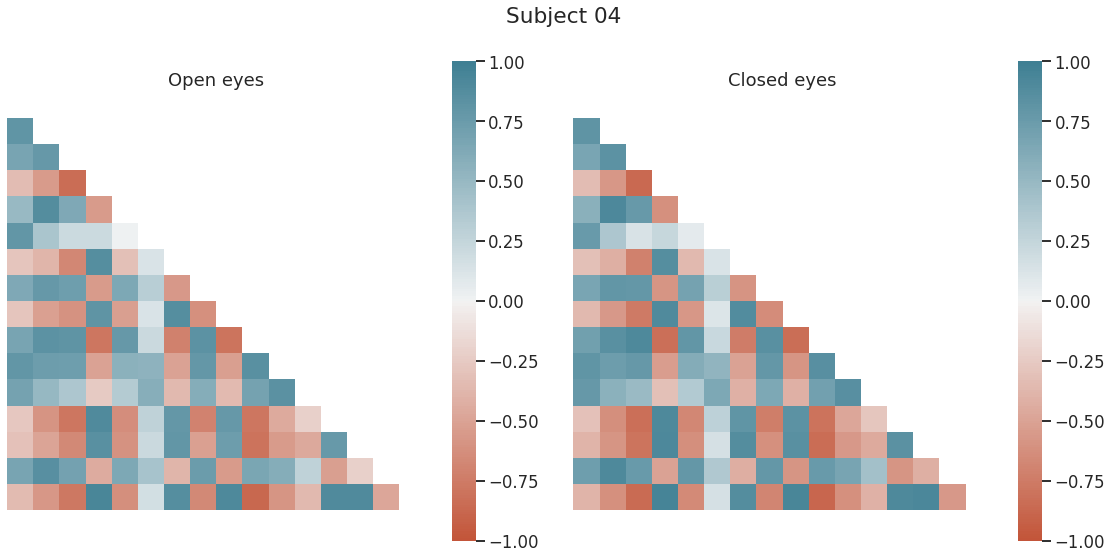

2.5208227629319913


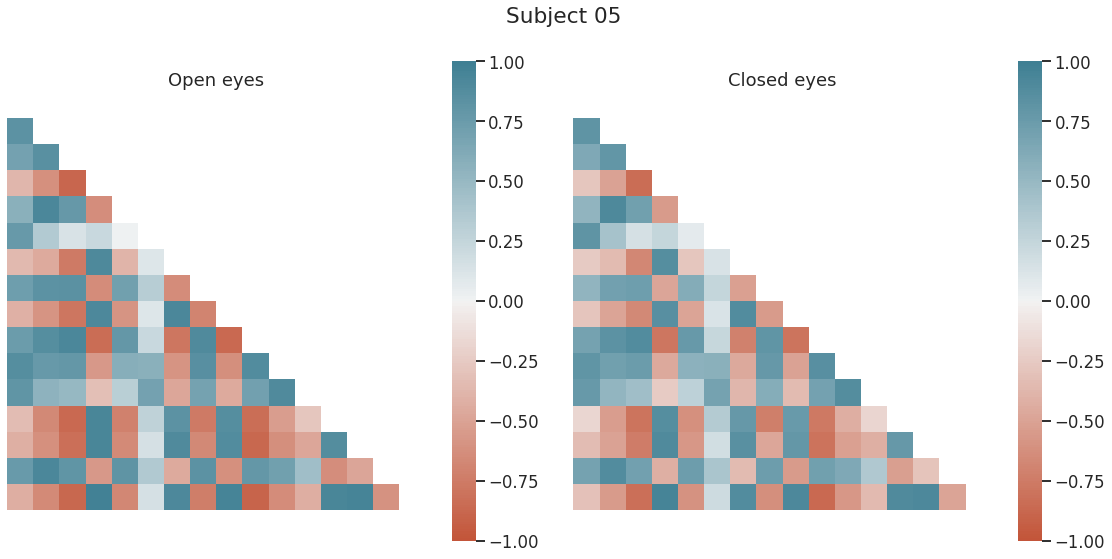

5.507529690190254


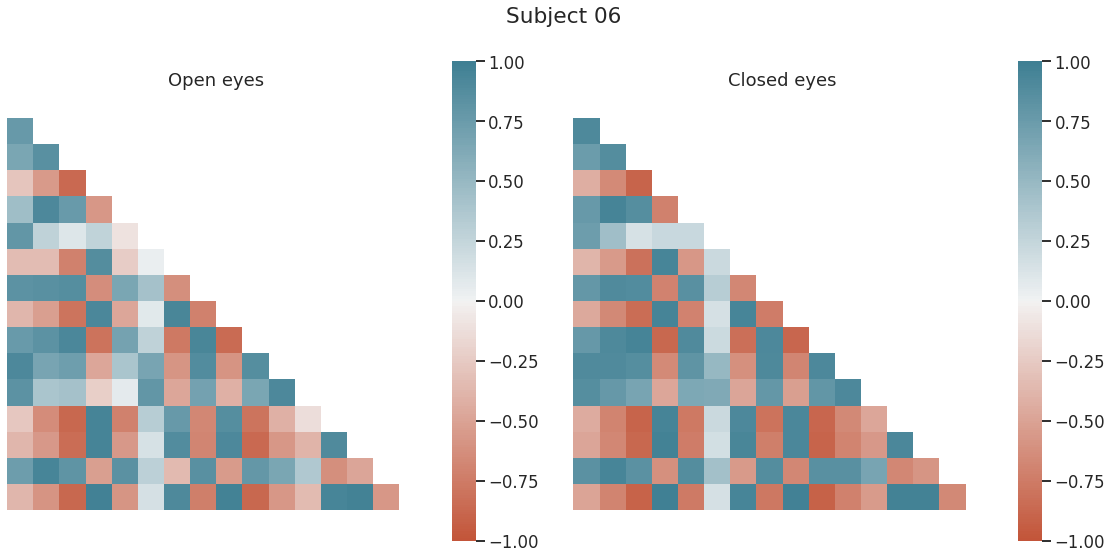

4.591927613276713


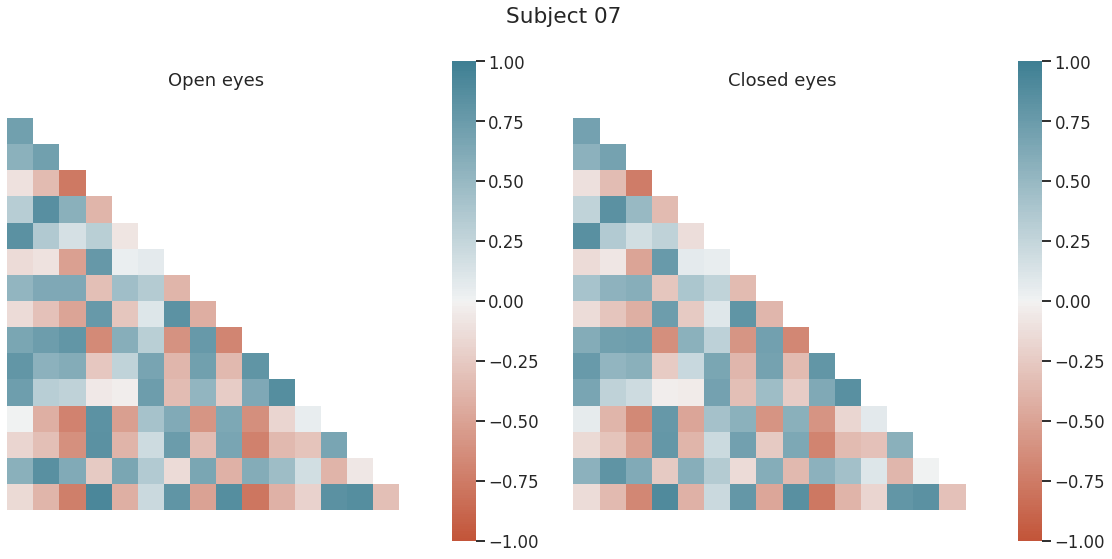

1.4097046519547662


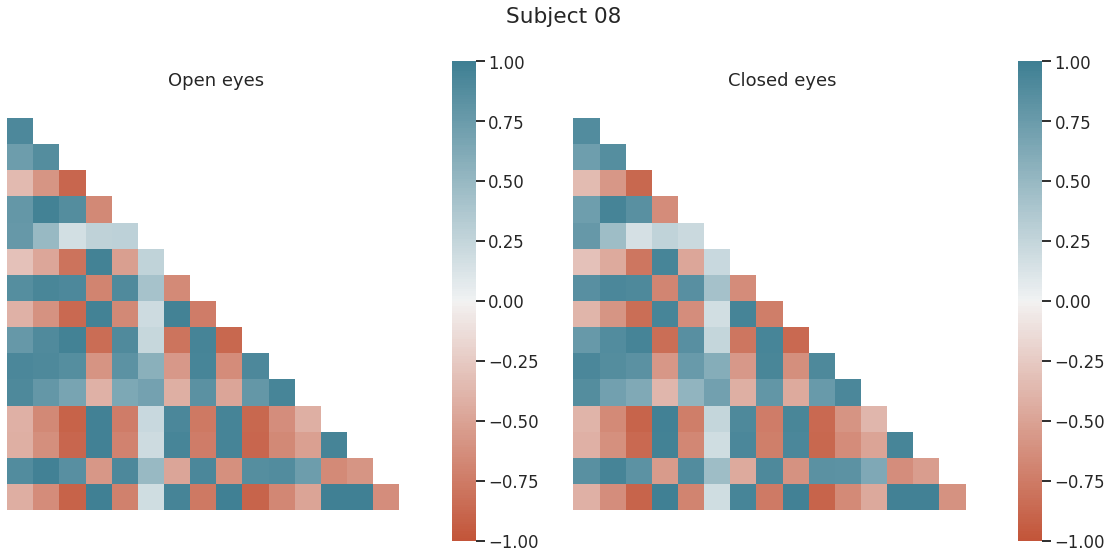

2.7817236393674847


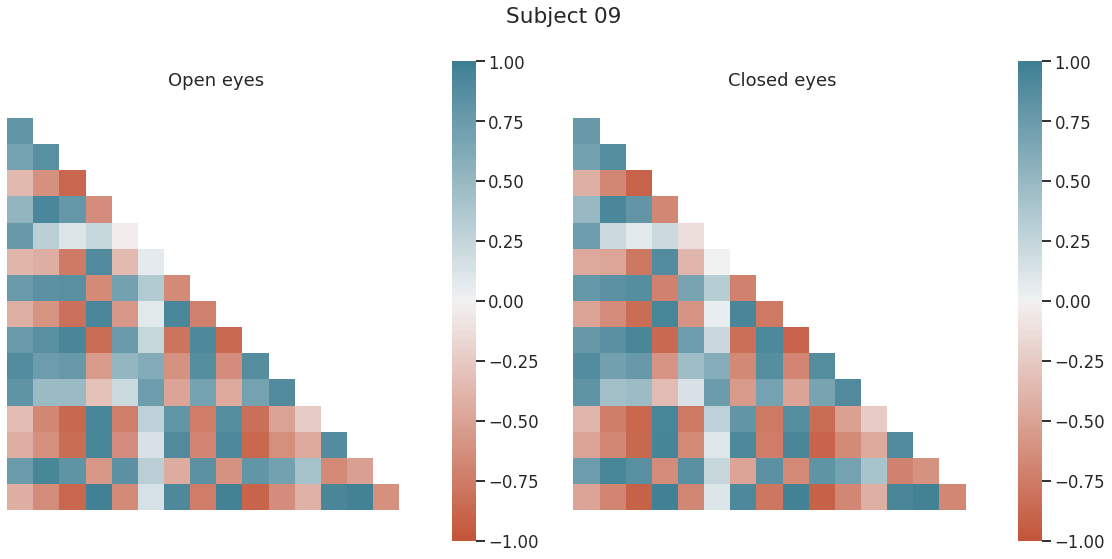

0.8293150890233767


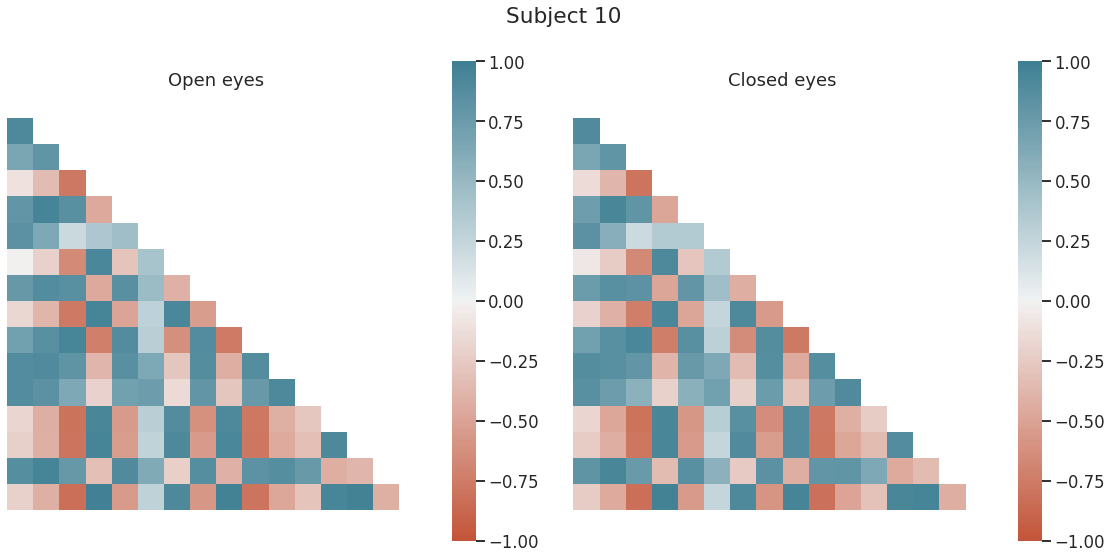

1.1820695642093466


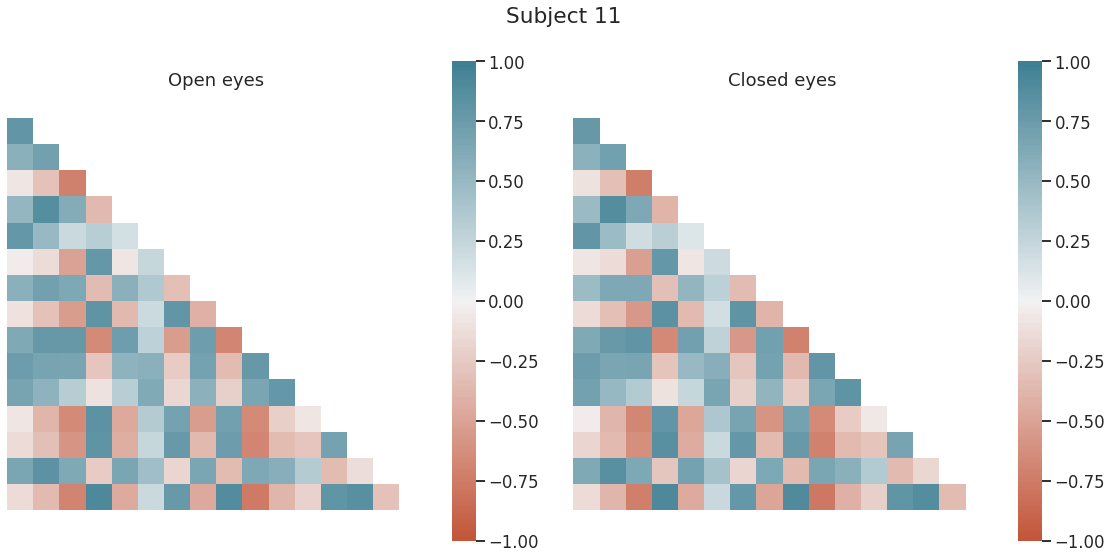

1.624446335335454


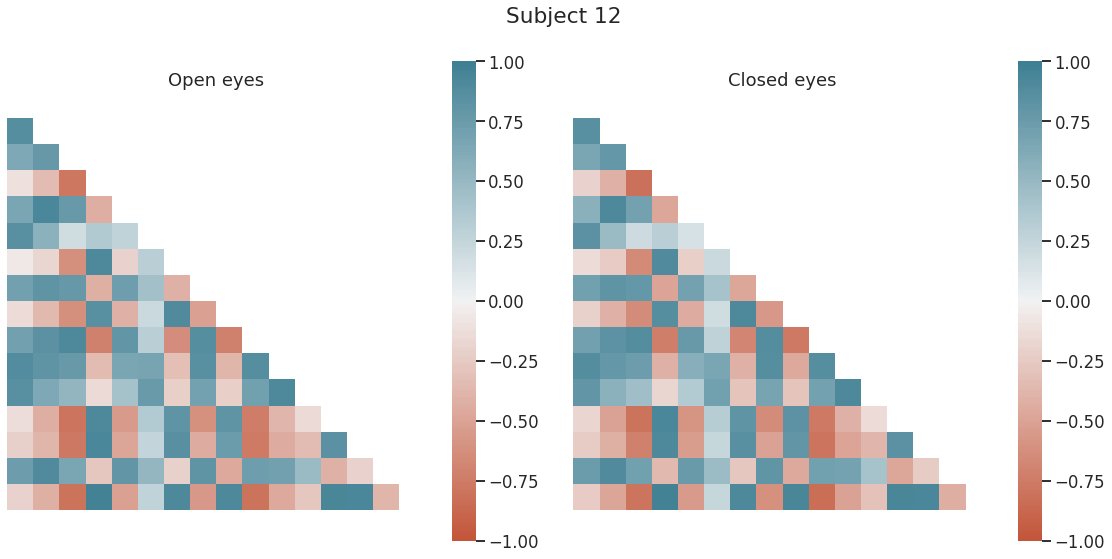

1.8951081862376433


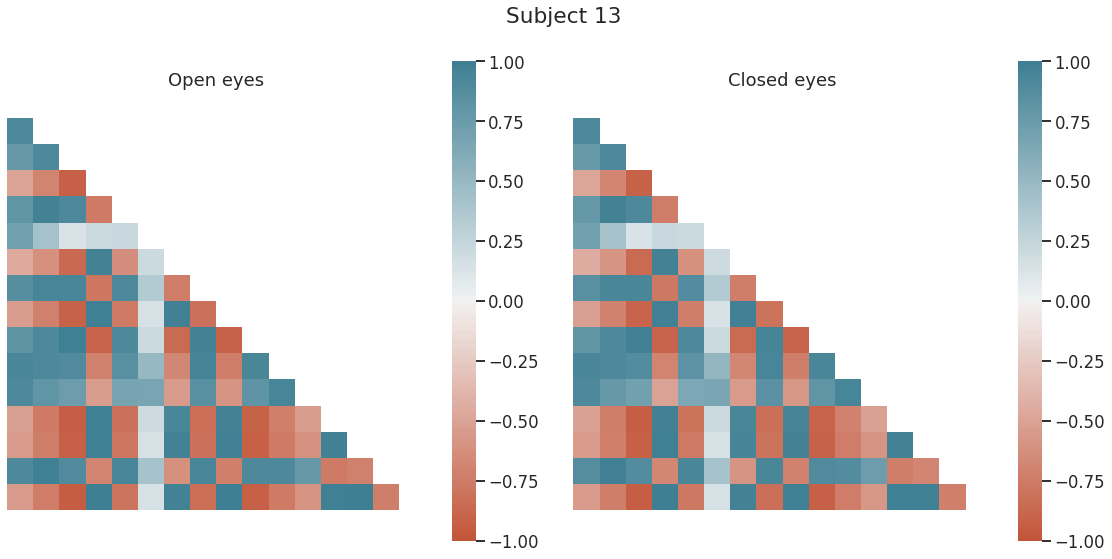

1.2934592086975363


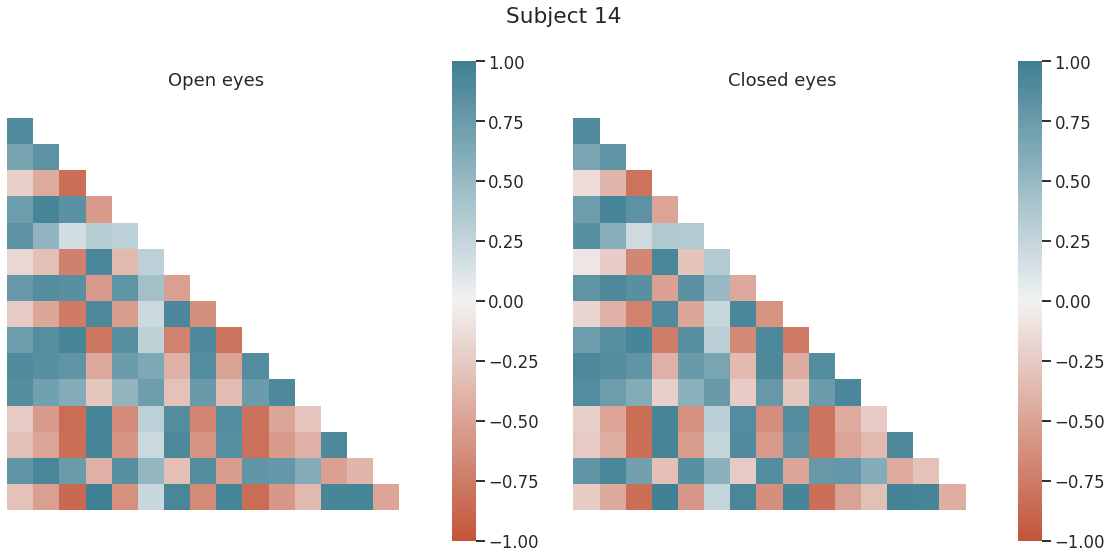

1.2812452855951428


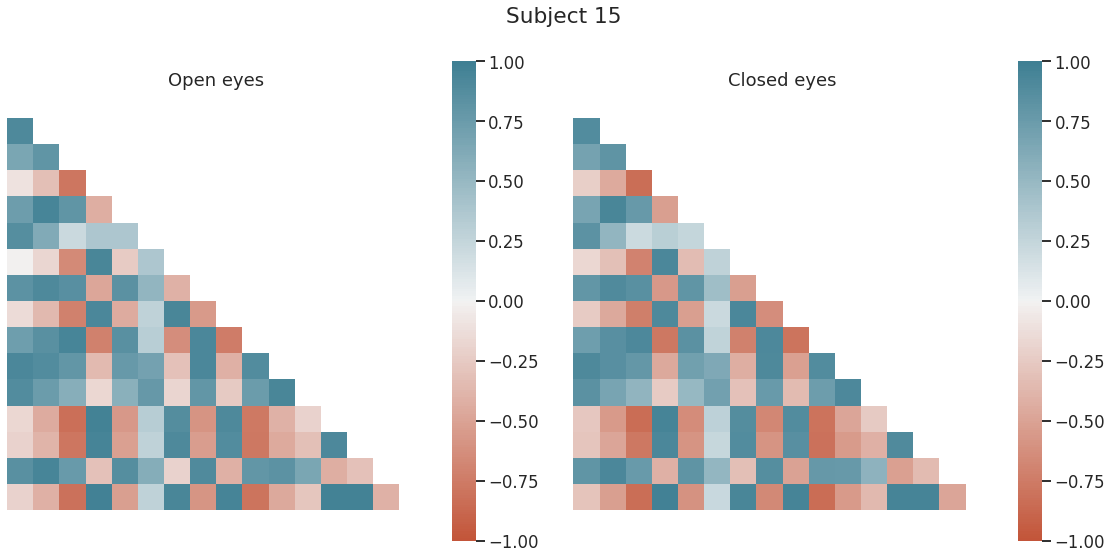

1.7790851845566822


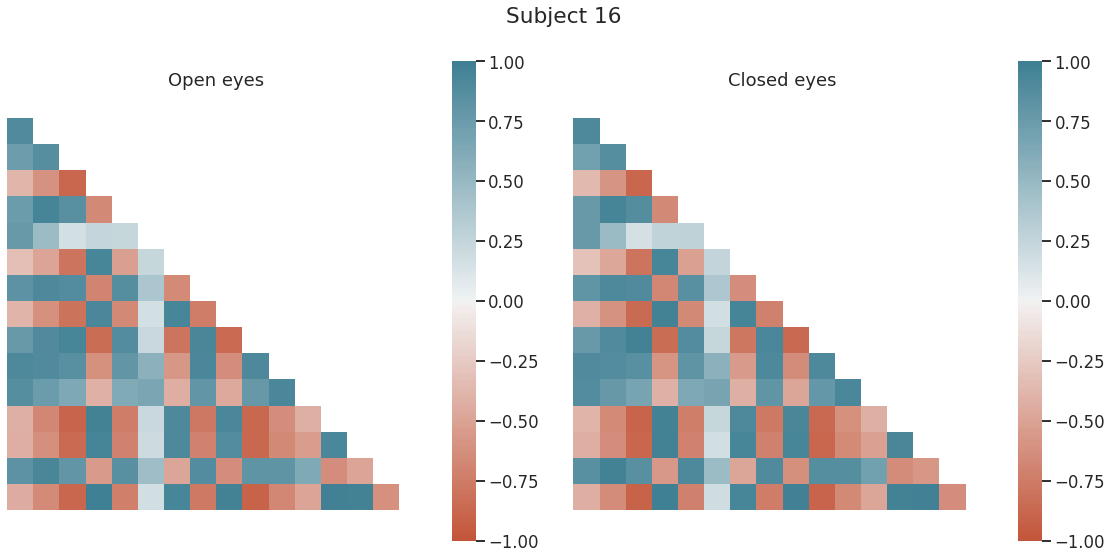

2.3143394059900473


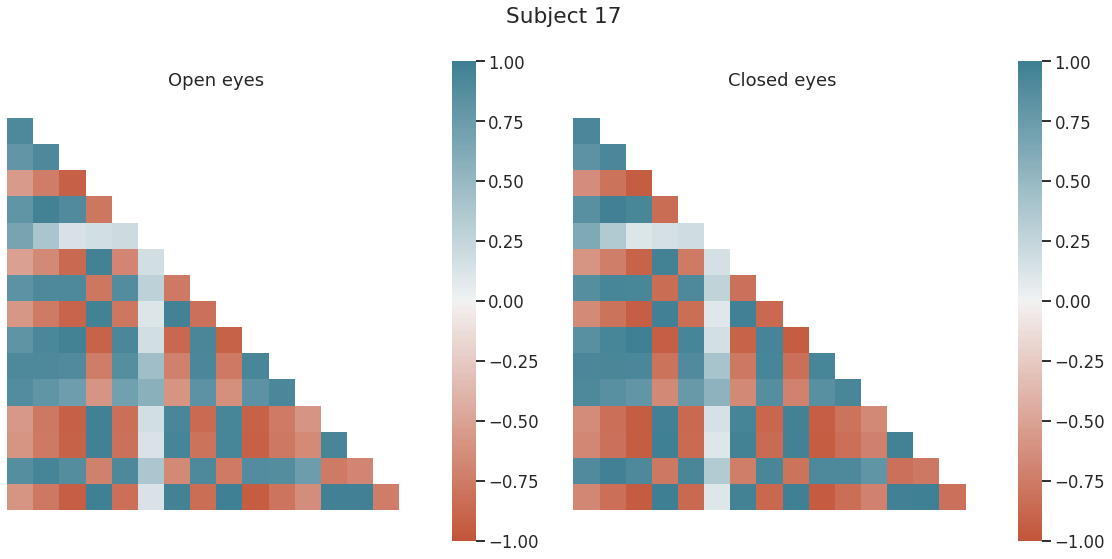

2.1576252102961373


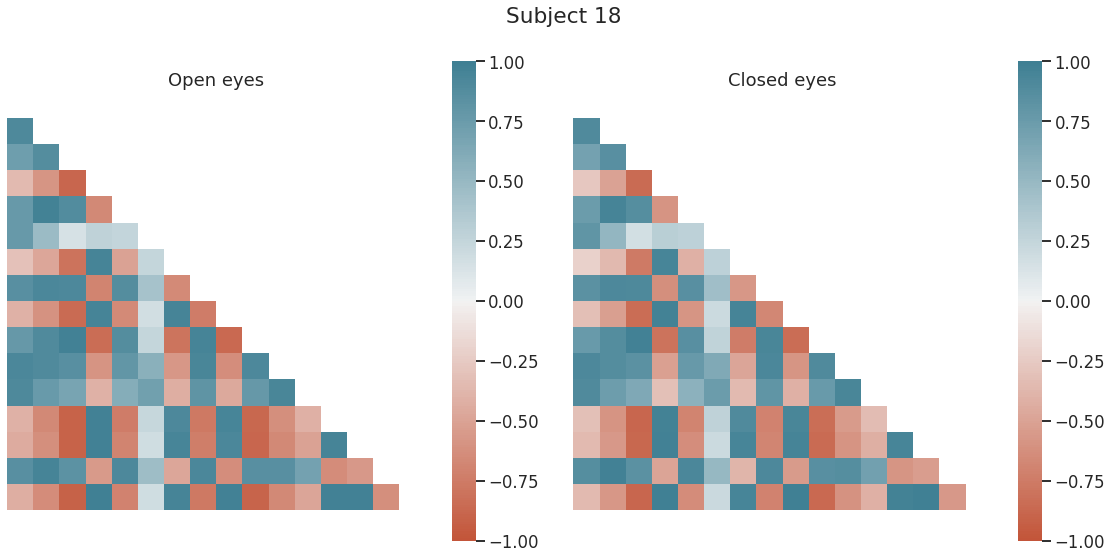

3.170357778045142


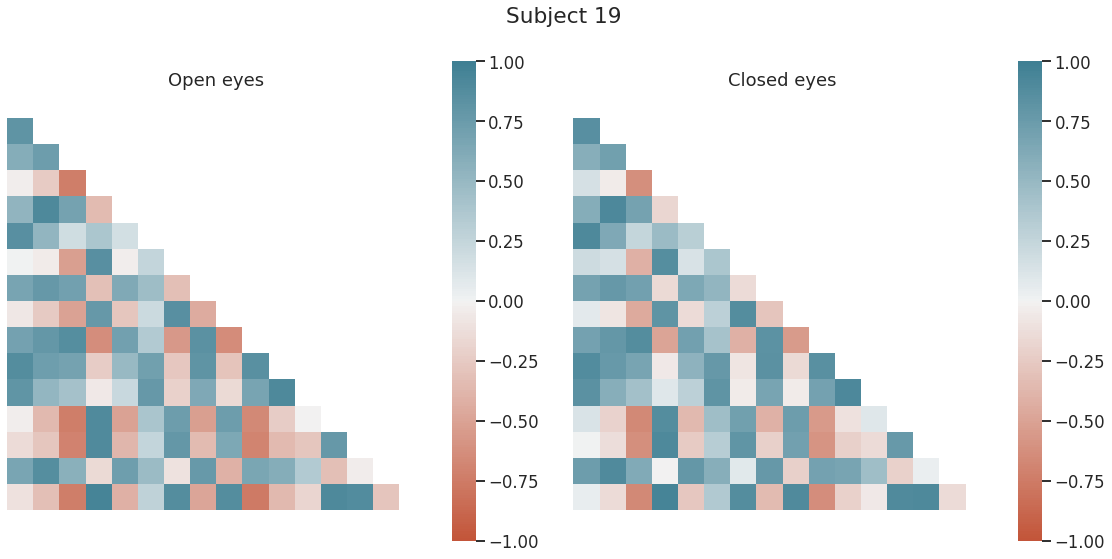

1.2898283856248973


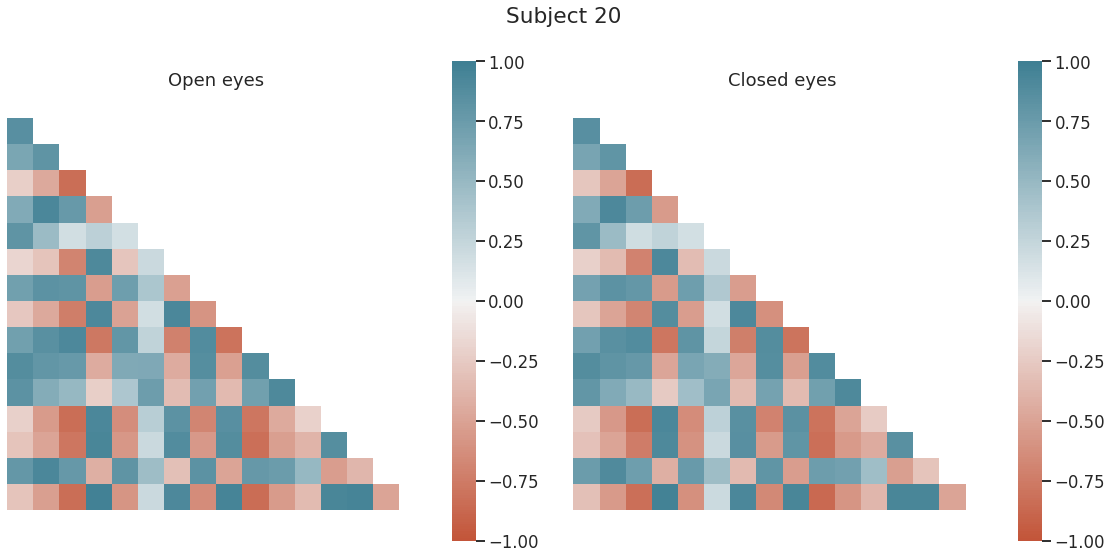

0.9157019768624581


In [9]:
for i in np.arange(0, 40, 2):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
    sns.heatmap(data=corr_from_cov(Sigmas_rotated[i]),
                ax=ax[0],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=corr_from_cov(Sigmas_rotated[i+1]),
                ax=ax[1],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    ax[0].set_title('Open eyes')
    ax[1].set_title('Closed eyes')
    f.suptitle("Subject {:02}".format(int(i/2 + 1)))
    plt.tight_layout()
    plt.show()
    print(dist_riem_squared(Sigmas_rotated[i], Sigmas_rotated[i+1]))

In [10]:
from jax import jit, grad
from optispd.manifold import SPD
from optispd.minimizer import minimizer

def karcher(sigmas):
    cost = jit(lambda x: jnp.sum(dist_riem_squared(x, jnp.array(sigmas))))
    gr = jit(grad(cost))
    init = jnp.mean(sigmas, axis=0)
    
    man = SPD(16)
    opti = minimizer(man, 'rcg', verbosity=1, maxiter=100)
    res = opti.solve(cost, gr, x=init)
    print(res)
    return np.array(res.x)
    
print('\t...Barycenter of not rotated')
ori_bar = karcher(Sigmas)
#ori_bar_close = karcher(Sigmas[Number_of_Subjects:])
#ori_bar_open = karcher(Sigmas[:Number_of_Subjects])
print('\n\t... Barycenter of rotated')
rot_bar = karcher(Sigmas_rotated)
#rot_bar_close = karcher(Sigmas_rotated[Number_of_Subjects:])
#rot_bar_open = karcher(Sigmas_rotated[:Number_of_Subjects])


	...Barycenter of not rotated
Starting Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices
Optimization not completed (status 5).	12 iterations in 3.902 s
Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices.
---
Success: False with status 5 in 3.902 s.
[status meaning: 0=converged, 1=stepsize too small, 2=max iters reached, 3=max time reached, 4=max cost evaluations, 5=function value not changing-1=undefined]
 -Iterations 12 (cost evaluation: 108, gradient evaluation: 108, time/it: 0.32514939705530804)
 	 Function value 4200.135, gradient norm 0.09509193136494665, stepsize 0.00161914216630357,
 	 value of X:
	... Too big to show...

	... Barycenter of rotated
Starting Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices
Optimization not completed (status 5).	6 iterations in 3.346 s
Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices.
---
Success: False with status 5 in

In [11]:
S = jnp.array(Sigmas)
S2 = jnp.array(Sigmas_rotated)

d1 = dist_riem_squared(ori_bar, S)
d2 = dist_riem_squared(rot_bar, S2)

df = pd.DataFrame({'Not rotated': d1, 'Rotated': d2, 'Eyes':labels, 'Ages':ages, 'Subject':subjects, 'Gender':genders})
df = pd.melt(df, 
             id_vars=['Eyes', 'Ages', 'Subject', 'Gender'],
             var_name="Kind",
             value_name="Distance from reference"
            )

def age_groups(x):
    if x <= 20:
        return '<= 20'
    elif x <= 25:
        return '20 < x <= 25'
    elif x <= 28:
        return '25 < x <= 28'
    else:
        return '> 28'

df['Age group'] = df.Ages.apply(lambda x: age_groups(x))

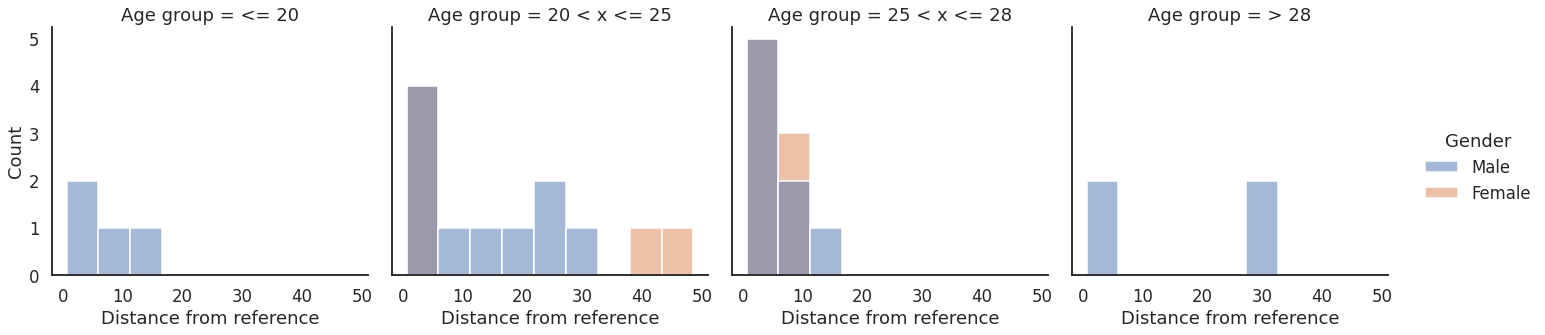

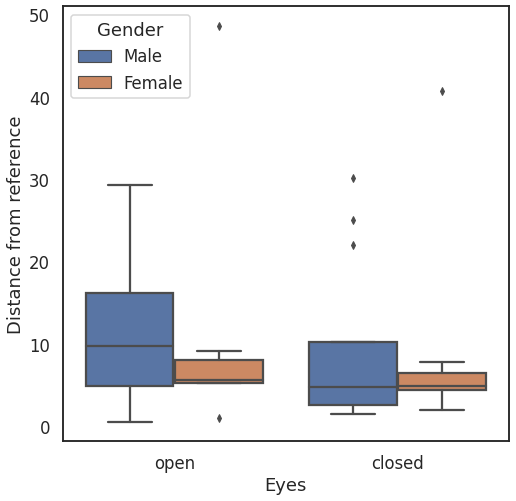

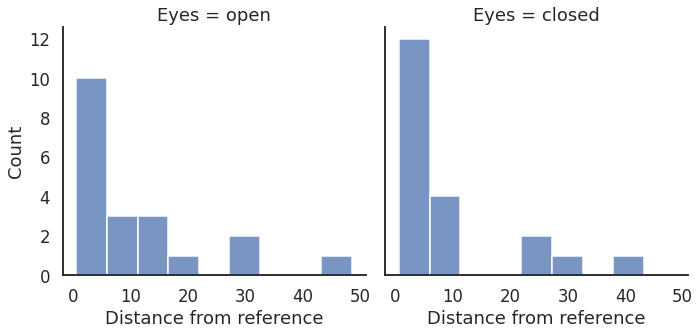

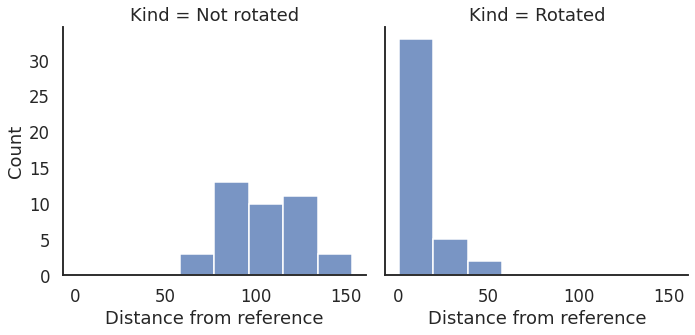

In [12]:
#f = plt.figure(figsize=(14,8))
sns.displot(data=df[df['Kind']=='Rotated'], 
            x='Distance from reference', 
            col='Age group', 
            hue='Gender',
            col_order=['<= 20', '20 < x <= 25', '25 < x <= 28', '> 28'],
           )
plt.show()

sns.boxplot(data=df[df['Kind']=='Rotated'],
            x='Eyes', 
            y='Distance from reference', 
            hue='Gender'
           )
plt.show()

sns.displot(data=df[df['Kind']=='Rotated'], 
            x='Distance from reference',
            col='Eyes',
            #hue='Gender',
            multiple='stack'
           )
plt.show()

sns.displot(data=df, 
            x='Distance from reference',
            col='Kind',
            multiple='stack'
           )
plt.show()

In [13]:
#df[(df['Kind'] == 'Rotated') & (df['Distance from reference'] > 20)]
# [s11, s3, s13, s7]
#df[(df['Kind'] == 'Not rotated') & (df['Distance from reference'] > 40)].sort_values('Distance from reference')

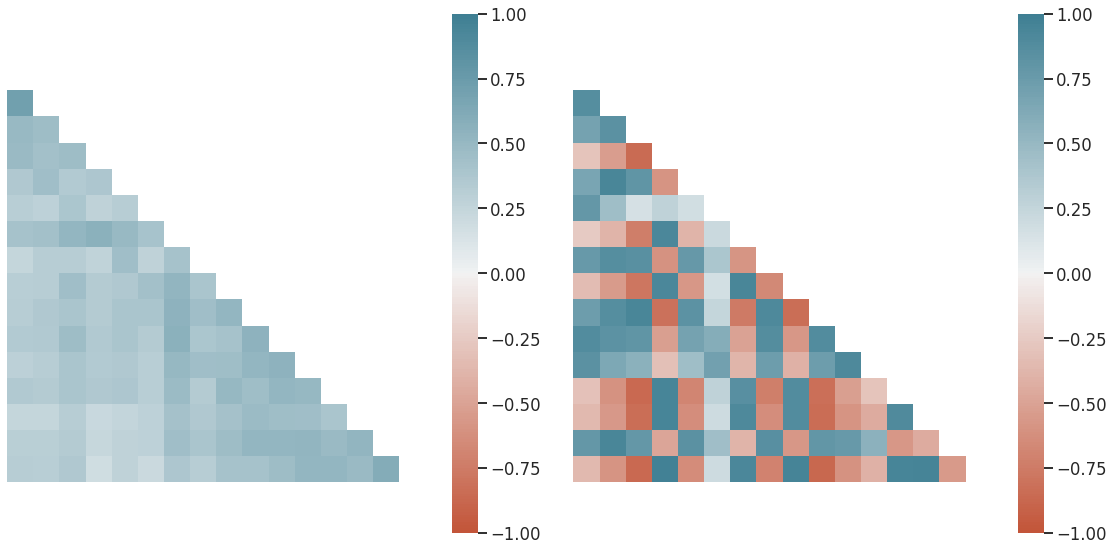

104.5070138072646


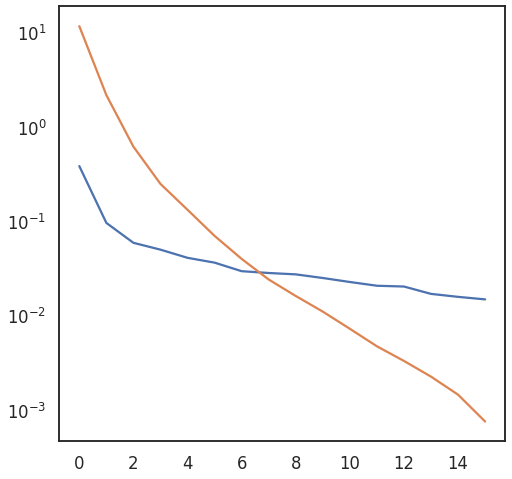

In [14]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
sns.heatmap(data=corr_from_cov(ori_bar), 
            ax=ax[0],
            vmin=s_min,
            vmax=s_max,
            cmap=colmap,
            mask=mask,
            square=True,
            yticklabels=False,
            xticklabels=False
           )

sns.heatmap(data=corr_from_cov(rot_bar),
            ax=ax[1],
            vmin=s_min,
            vmax=s_max,
            cmap=colmap,
            mask=mask,
            square=True,
            yticklabels=False,
            xticklabels=False
           )
f.set_tight_layout(tight=True)
plt.show()
print(dist_riem_squared(rot_bar, ori_bar))

plt.plot(range(16), np.linalg.eigvalsh(ori_bar)[::-1])
plt.plot(range(16), np.linalg.eigvalsh(rot_bar)[::-1])
plt.yscale('log')
plt.show()

In [18]:
chnames = ['Fp1',
           'Fp2',
           'FC5',
           'Fz',
           'FC6',
           'T7',
           'Cz',
           'T8',
           'P7',
           'P3',
           'Pz',
           'P4',
           'P8',
           'O1',
           'Oz',
           'O2'
          ]
chtypes = ['eeg'] * len(chnames)
info = mne.create_info(ch_names=chnames, sfreq=512, ch_types=chtypes, verbose=False)
info.set_montage('standard_1020')
nfree = np.mean(lengths)

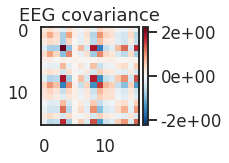

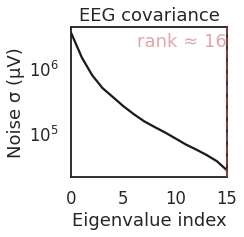

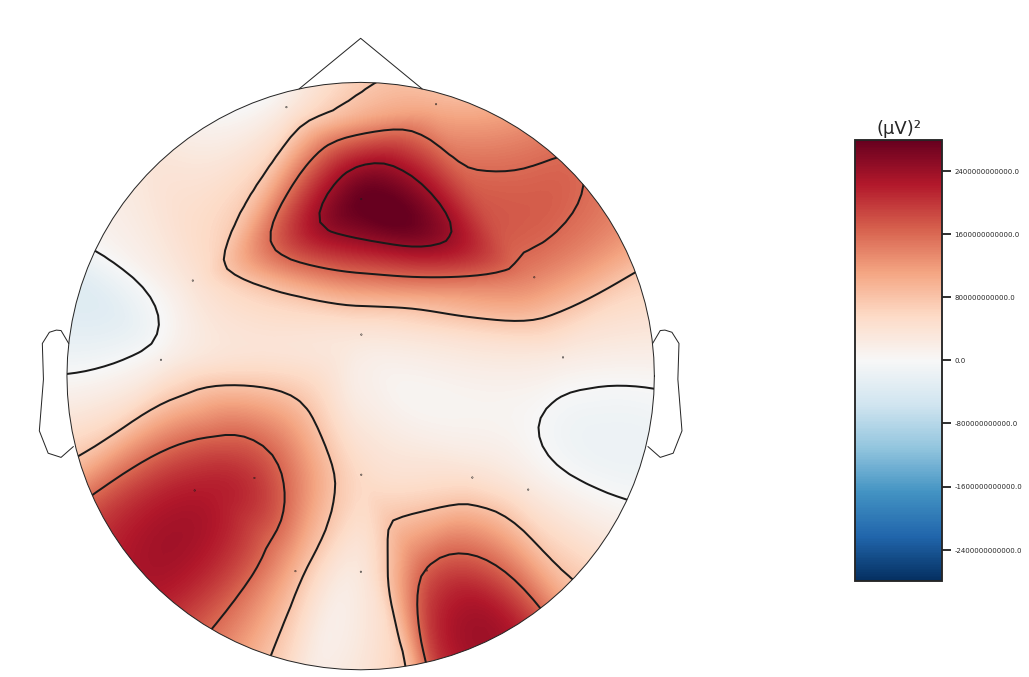

In [19]:
cov_rot = mne.Covariance(rot_bar, chnames, bads=[], projs=[], nfree=nfree, verbose=False)
cov_rot.plot(info)
cov_rot.plot_topomap(info, size=8)
plt.show()

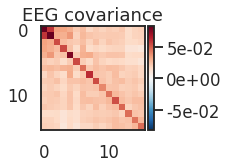

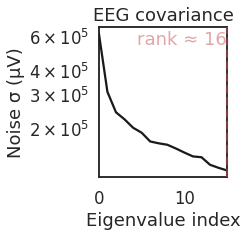

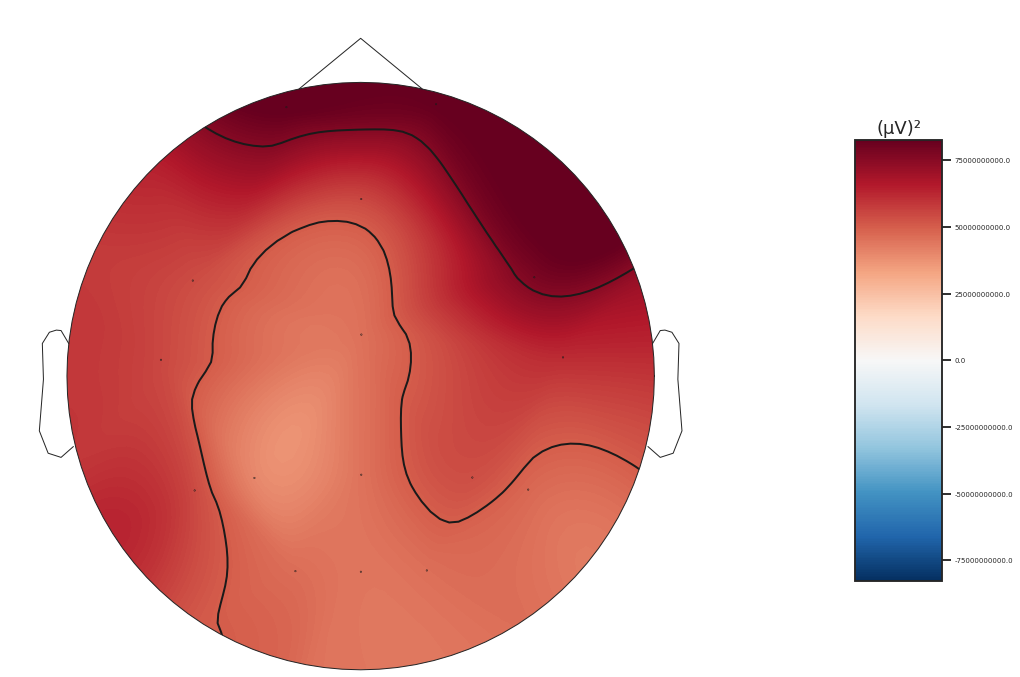

In [20]:
cov_ori = mne.Covariance(ori_bar, chnames, bads=[], projs=[], nfree=nfree, verbose=False)
cov_ori.plot(info)
cov_ori.plot_topomap(info, size=8)
plt.show()

```
print("OPEN EYES")
f, ax = plt.subplots(Number_of_Subjects, 2, sharex=True, sharey=True, figsize=figsize)
for i in range(Number_of_Subjects):
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas[i])), 
                ax=ax[i, 0],
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[i])), 
                ax=ax[i, 1],
                vmin=s_max_ro,
                vmax=s_min_ro,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
ax[0,0].set_title('Original')
ax[0,1].set_title('Rotated')
#f.suptitle('Open eyes')
f.set_tight_layout(tight=True)
plt.show()
```

```
print("CLOSED EYES")
f, ax = plt.subplots(Number_of_Subjects, 2, sharex=True, sharey=True, figsize=figsize)
for i in range(Number_of_Subjects):
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas[Number_of_Subjects + i])), 
                ax=ax[i, 0],
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[Number_of_Subjects + i])), 
                ax=ax[i, 1],
                vmin=s_max_ro,
                vmax=s_min_ro,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
ax[0,0].set_title('Original')
ax[0,1].set_title('Rotated')
# f.suptitle('Closed eyes')
f.set_tight_layout(tight=True)
plt.show()
```

```
f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[1])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_1.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[1])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_1_rot.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[3])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_3.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[3])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_3_rot.pdf')
plt.show()


f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[6])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_6.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[6])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_6_rot.pdf')
plt.show()
```

```
print("CLOSED EYES")
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar_close)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar_close)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()
```

```
print("OPEN EYES")
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar_open)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar_open)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()
```